In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings('ignore')

In [53]:
df = pd.read_csv('January_MyCall_2022.csv')
df.head()

,operator,inout_travelling,network_type,rating,calldrop_category,latitude,longitude,state_name
0,BSNL,Indoor,3G,3,Satisfactory,-1.000000,-1.00000,NA
1,BSNL,Indoor,2G,3,Poor Voice Quality,-1.000000,-1.00000,NA
2,BSNL,Indoor,2G,3,Satisfactory,-1.000000,-1.00000,NA
3,BSNL,Indoor,3G,3,Satisfactory,-1.000000,-1.00000,NA
4,RJio,Outdoor,4G,4,Satisfactory,18.519782,73.85619,Maharashtra


# Exploration de données

In [54]:
# Visualisation des valeurs manquantes
(df.isna().sum() / df.shape[0]).sort_values()

operator             0.0
inout_travelling     0.0
network_type         0.0
rating               0.0
calldrop_category    0.0
latitude             0.0
longitude            0.0
state_name           0.0
dtype: float64

In [55]:
df['calldrop_category'].value_counts(normalize=True)*100

Satisfactory          64.032258
Poor Voice Quality    22.903226
Call Dropped          13.064516
Name: calldrop_category, dtype: float64

- On peut remarquer que les données sont déséquilibrés, il faudra donc en tenir compte lors de l'élaboration du modéle
- La variable target est : calldrop_category

In [56]:
df.shape

(620, 8)

In [57]:
df.dtypes.value_counts()

object     5
float64    2
int64      1
dtype: int64

# Analyse Univarié

In [58]:
var_cat = []

for col in df.select_dtypes('object'):
    var_cat.append(col)

len(var_cat)

5

In [59]:
var_num  = []

for col in df.select_dtypes('float'):
    var_num.append(col)
    
for col in df.select_dtypes('int'):
    var_num.append(col)
    
len(var_num)

3

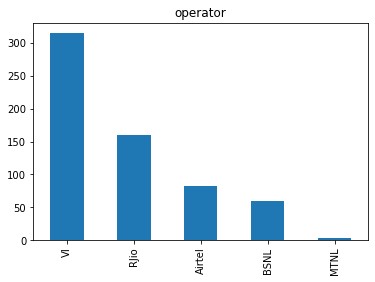

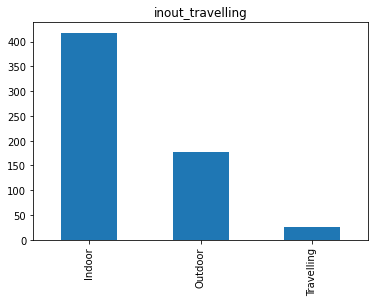

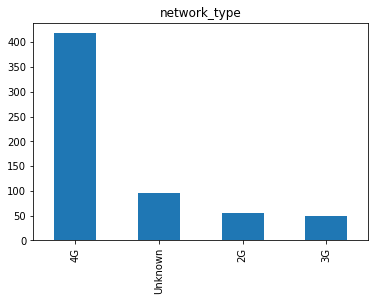

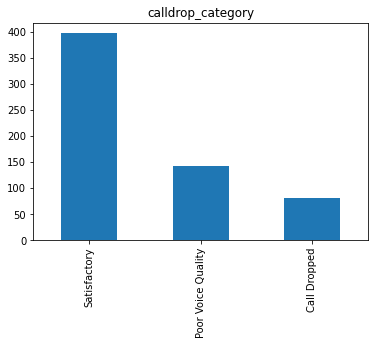

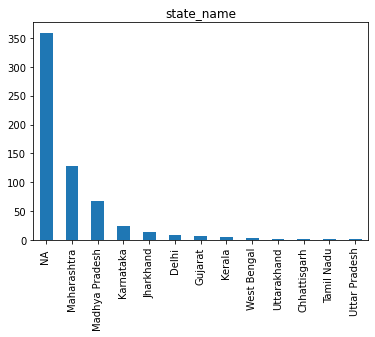

In [60]:
# Visualisation de toute les variables catégoriques

for col in var_cat:
    plt.figure()
    df[col].value_counts().plot.bar()
    plt.title(col)

- L'operateur VI est le plus populaire en Inde
- La majorité des personnes utilise la 4g
- La majorité des utilisateurs sont satisfaits de l'appel
- La majorité des utilisateurs sont dans la ville NA

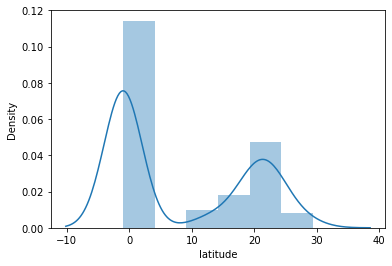

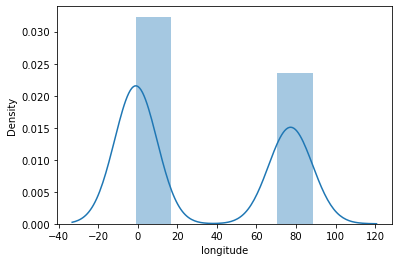

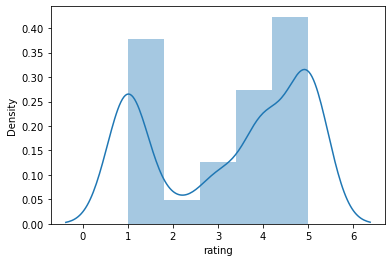

In [61]:
# Visualisation des valeurs numériques
for col in var_num:
    plt.figure()
    sns.distplot(df[col])

- La majorité des utilisateurs passent leur coup de fil depuis un endroit de latitude entre -10 et 10
-  La majorité des utilisateurs passent leur coup de fil depuis un endroit de longitude entre -20 et 20
- Les notes les plus fréquente attribué sont entre 4 et 6

# Analyse Bivarié

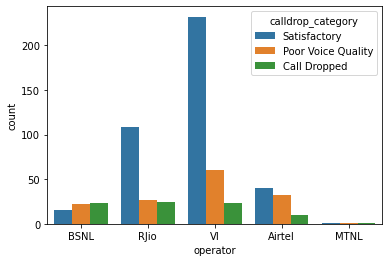

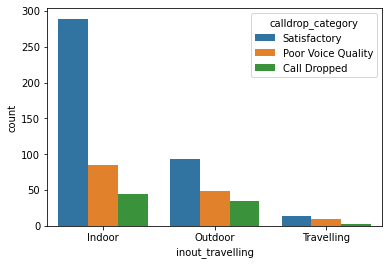

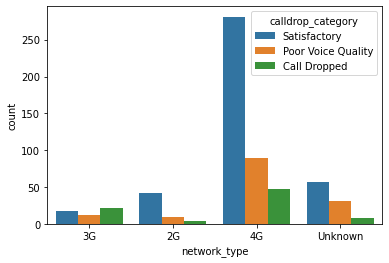

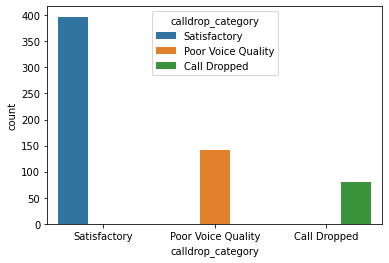

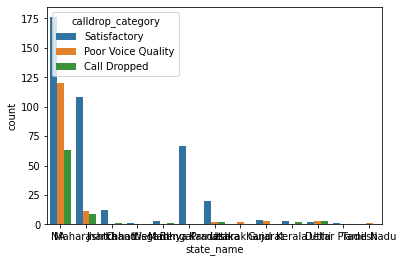

In [62]:
# Visualisation des relations entre les variables catégoriques et la target

for col in var_cat:
    plt.figure()
    sns.countplot(x=col , data=df , hue='calldrop_category')

- Lorsque l'utilisateur utilise l'operateur VI ou Rjio, il est fort probable qu'il soit satisfait de son appel sinon c'est le contraire qui se passe
- Quand l'appel est passé en intérieur, c'est là où il a le plus de chance d'être satisfaisant pour l'utilisateur
- La 4g a de loin les meilleurs chances de procuré un appel satisfaisant pour le client
- De maniére général, il y'a plus de chance que l'utilisateur soit content de son appel que l'inverse

In [63]:
satisfait_df = df[df['calldrop_category'] == 'Satisfactory']
non_satisfait_df = df[df['calldrop_category'] == 'Poor Voice Quality']
appel_manque_df = df[df['calldrop_category'] == 'Call Dropped']

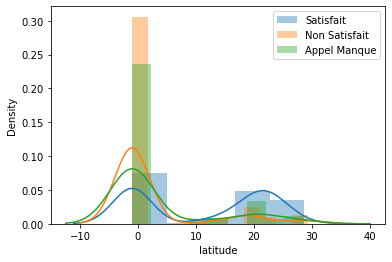

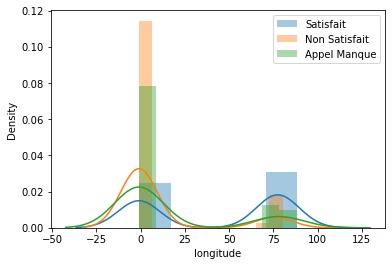

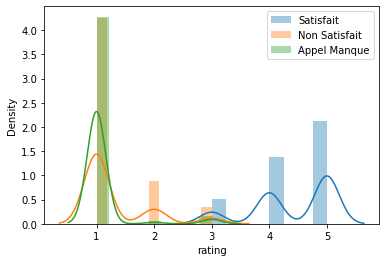

In [64]:
# Visualisation des relations entre les variables continue et la target

for col in var_num:
    plt.figure()
    sns.distplot(satisfait_df[col] , label='Satisfait')
    sns.distplot(non_satisfait_df[col] , label = 'Non Satisfait')
    sns.distplot(appel_manque_df[col] , label = 'Appel Manque')
    plt.legend()

- Plus la latitude et la longitude sont élevé, plus l'utilisateur a de chance d'être satisfait
- Pour une note de 1 : Il est fort probable que l'appel soit manqué
- Pour une note de 2 : Il est fort probable que l'appel soit de mauvaise qualité
- Pour une note supérieur ou égal à 3 : Il est fort probable que l'appel soit de satisfaisant

# Encodage des données

In [65]:
from sklearn.preprocessing import LabelEncoder

for col in var_cat:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
df['calldrop_category'].value_counts()

2    397
1    142
0     81
Name: calldrop_category, dtype: int64

In [66]:
X = df.drop(['calldrop_category'],axis=1)
y = df['calldrop_category']

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [68]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=6)

In [69]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [70]:
rUs = RandomOverSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

In [71]:
model = make_pipeline(StandardScaler(),RandomForestClassifier())
model.fit(X_ru , y_ru)
model.score(X_test,y_test)

0.9354838709677419

In [72]:
from sklearn.model_selection import cross_val_score
cross_val_score(model,X_ru,y_ru,cv=3).mean()

0.8450854700854701

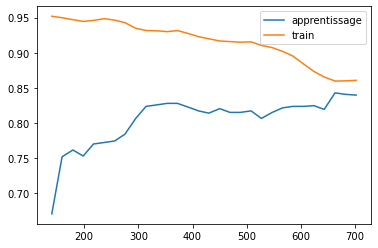

In [73]:
from sklearn.model_selection import learning_curve

N , train_score , val_score = learning_curve(model , X_ru , y_ru , train_sizes=np.linspace(0.2,1.0,30) , cv=4)

plt.plot(N , val_score.mean(axis=1) , label = 'apprentissage')
plt.plot(N , train_score.mean(axis=1) , label = 'train')
plt.legend()

In [74]:
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score

In [75]:
pred = model.predict(X_test)

In [76]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80        17
           1       0.86      0.82      0.84        22
           2       0.99      0.99      0.99        85

    accuracy                           0.94       124
   macro avg       0.87      0.88      0.88       124
weighted avg       0.94      0.94      0.94       124

